In [1]:
from scipy.stats import spearmanr, pearsonr

from bertscore import BERTScore
from conventional_metrics import BLEU, METEOR
from scm import SCM, ContextualSCM
from wmd import WMD, ContextualWMD
from common import Evaluator
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/home/xstefan3/miniconda3/envs/new_hf/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/xstefan3/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/xstefan3/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/xstefan3/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/xstefan3/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/xstefan3/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/xstefan3/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Evaluating lang pair cs-en


WMD_contextual: construct contextual embeddings: 1120it [00:00, 2564.80it/s]
SCM_contextual: construct contextual embeddings: 1120it [00:00, 2438.87it/s]
WMD: 100%|██████████| 560/560 [00:02<00:00, 233.47it/s]


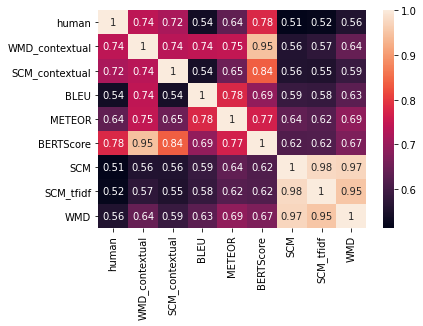

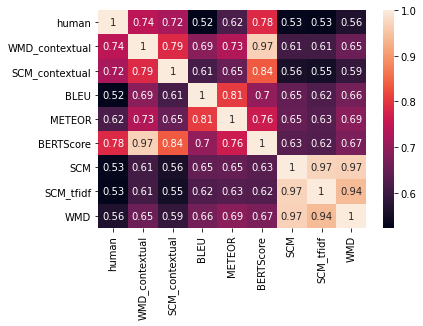

Evaluating lang pair de-en


WMD_contextual: construct contextual embeddings: 1120it [00:00, 2099.29it/s]
SCM_contextual: construct contextual embeddings: 1120it [00:00, 2465.71it/s]
WMD: 100%|██████████| 560/560 [00:02<00:00, 236.95it/s]


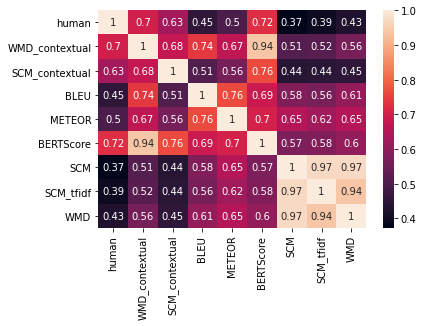

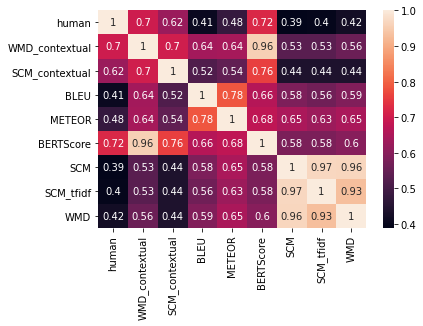

Evaluating lang pair fi-en


WMD_contextual: construct contextual embeddings: 1120it [00:00, 2122.06it/s]
SCM_contextual: construct contextual embeddings: 1120it [00:00, 1834.07it/s]
WMD: 100%|██████████| 560/560 [00:03<00:00, 170.14it/s]


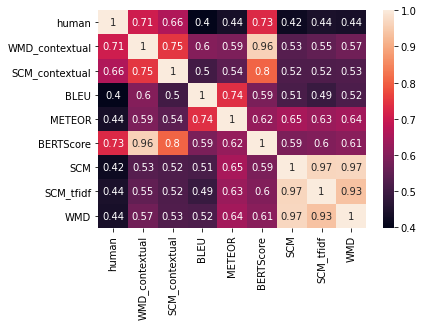

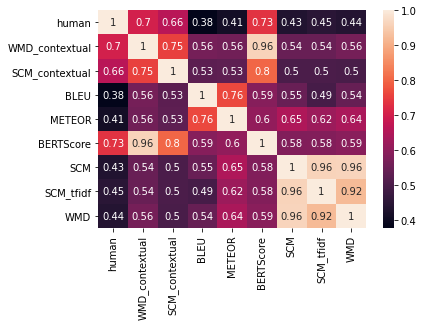

Evaluating lang pair ru-en


WMD_contextual: construct contextual embeddings: 1120it [00:00, 1861.76it/s]
SCM_contextual: construct contextual embeddings: 1120it [00:00, 2280.32it/s]
WMD: 100%|██████████| 560/560 [00:03<00:00, 175.08it/s]


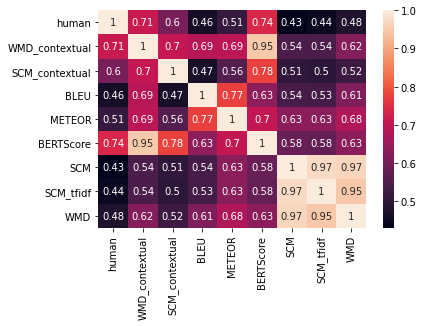

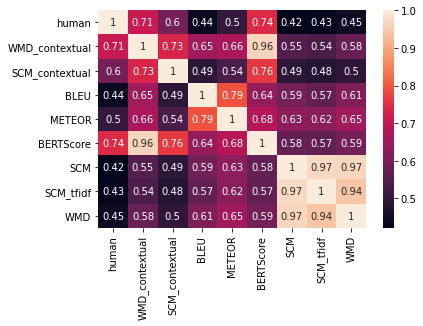

In [2]:
metrics = [
    ContextualWMD(tgt_lang="en"),
    ContextualSCM(tgt_lang="en"),
    BLEU(),
    METEOR(),
    BERTScore(tgt_lang="en"),
    SCM(tgt_lang="en", use_tfidf=False),
    SCM(tgt_lang="en", use_tfidf=True),
    WMD(tgt_lang="en"),
]

correlations = {m.label: {} for m in metrics}
correlations["human"] = {}

correlations_p = correlations.copy()
reports = []
langs = Evaluator.langs

selected_lang_pairs = [pair for pair in langs if pair.split("-")[-1] == "en"]

for lang_pair in selected_lang_pairs:
    print("Evaluating lang pair %s" % lang_pair)
    evaluator = Evaluator("data_dir", lang_pair, metrics)
    report = evaluator.evaluate()
    reports.append(report)

    human_judgements = report["human"]
#     for metric_label, vals in report.items():
#         correlations[metric_label][lang_pair] = spearmanr(vals, human_judgements).correlation
#         correlations_p[metric_label][lang_pair] = pearsonr(vals, human_judgements)[0]


    sns.heatmap(pd.DataFrame(report).applymap(float).corr(method="pearson").applymap(abs), annot=True)
    plt.show()
    sns.heatmap(pd.DataFrame(report).applymap(float).corr(method="spearman").applymap(abs), annot=True)
    plt.show()

# corrs_df = pd.DataFrame(correlations)

<AxesSubplot:>

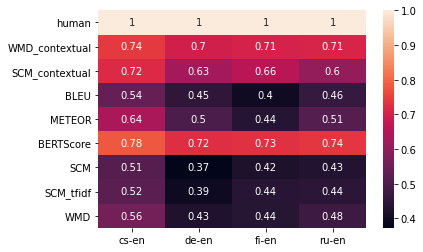

In [3]:
corrs_p = pd.concat([pd.DataFrame(report).corr(method="pearson").abs()["human"] for report in reports], axis=1)
corrs_p.columns = selected_lang_pairs
sns.heatmap(pd.DataFrame(corrs_p), annot=True)

<AxesSubplot:>

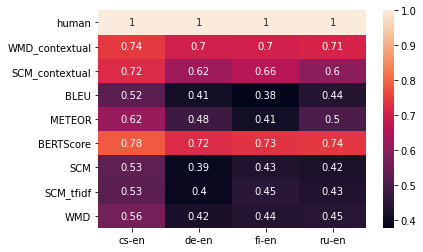

In [4]:
corrs_p = pd.concat([pd.DataFrame(report).corr(method="spearman").abs()["human"] for report in reports], axis=1)
corrs_p.columns = selected_lang_pairs
sns.heatmap(pd.DataFrame(corrs_p), annot=True)